<a href="https://colab.research.google.com/github/YUCAVALCANTE/ML_Studies/blob/main/vies%2C_variancia_e_trad_off_MAE_(R%24)_e_RMSE_(R%24).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

            model   MAE (R$)   RMSE (R$)
Gradient Boosting 945.192921 1181.715449
    Random Forest 944.464655 1192.661618
    Decision Tree 967.997810 1228.200621


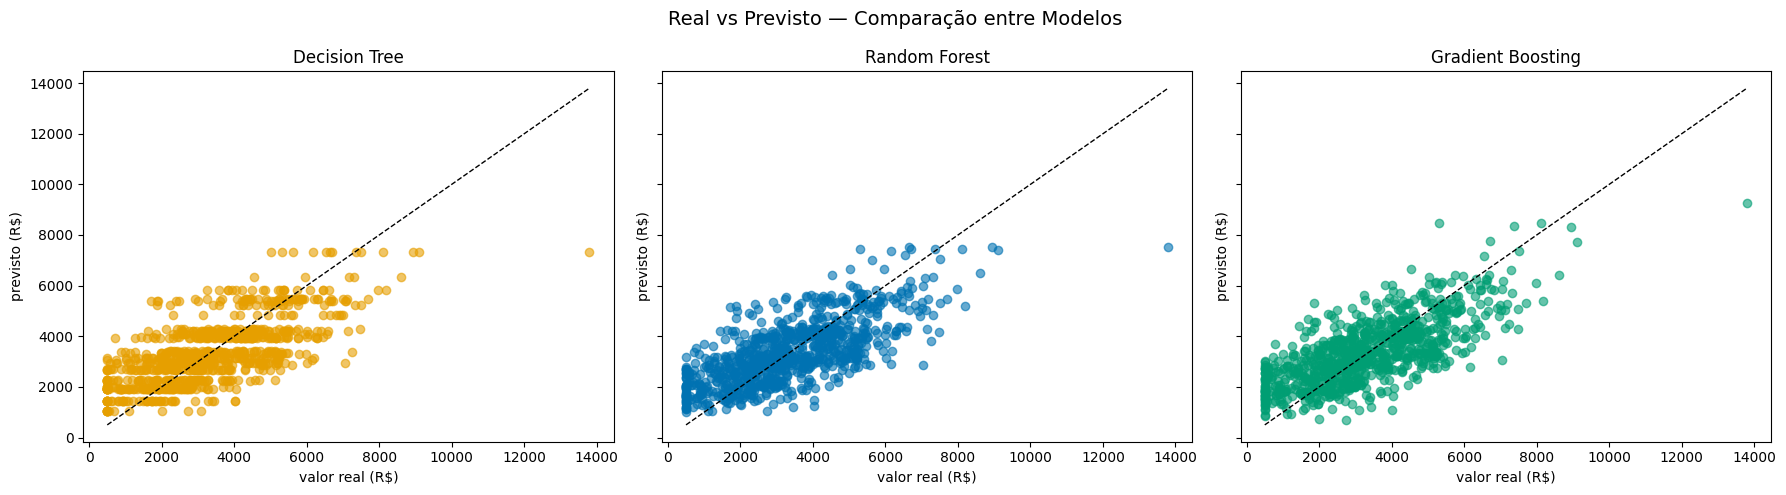

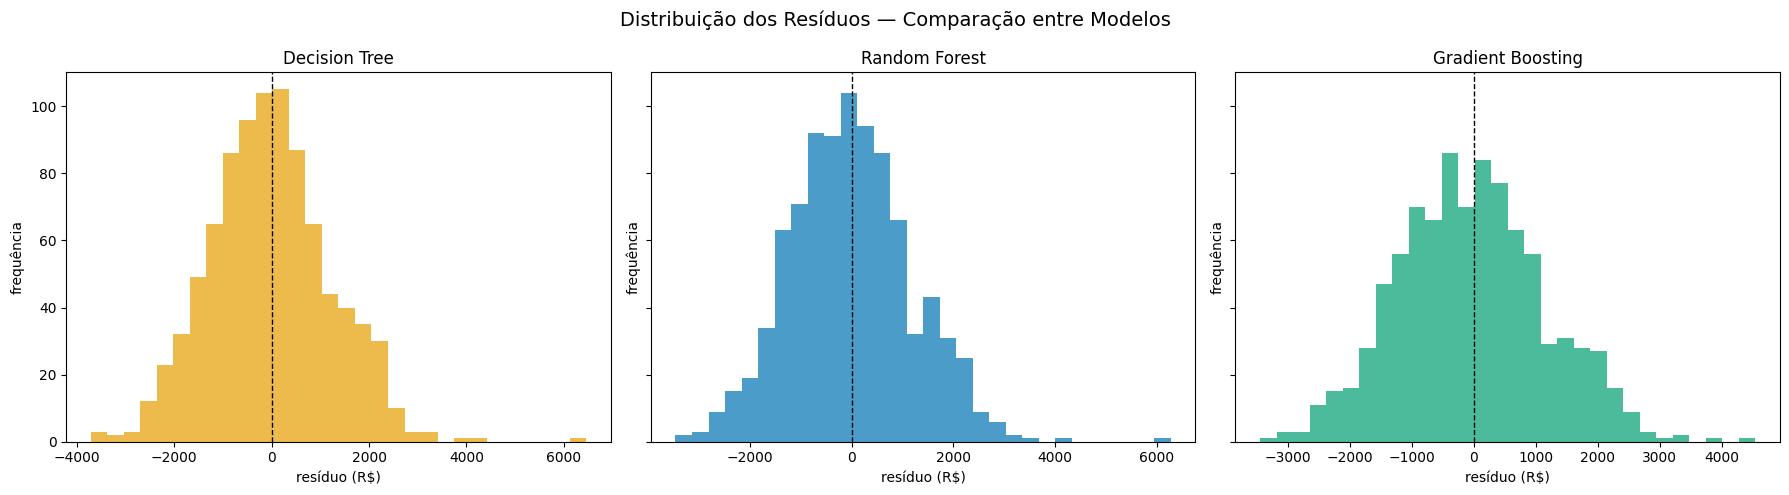

In [10]:
# O que este bloco faz:
# 1) gera uma base sintética de limite de crédito
# 2) treina três modelos (Decision Tree, Random Forest, Gradient Boosting)
# 3) compara MAE e RMSE (erro típico vs erro extremo)
# 4) plota Real vs Previsto + histograma dos resíduos

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error


# -----------------------------
# 0) Base sintética — limite de crédito
# -----------------------------
np.random.seed(42)
n = 3000

df = pd.DataFrame({
    "renda_mensal": np.random.normal(4000, 1500, n).clip(800, None),
    "idade": np.random.randint(18, 70, n),
    "tempo_emprego": np.random.exponential(4, n).clip(0, 40),
    "tipo_contrato": np.random.choice(["CLT", "PJ", "Autonomo"], n, p=[0.60, 0.25, 0.15]),
    "regiao": np.random.choice(["Sudeste", "Sul", "Nordeste", "Centro-Oeste"], n)
})

# relação não linear + ruído
df["limite_credito"] = (
    df["renda_mensal"] * 0.35
    + df["tempo_emprego"] * 250
    + np.where(df["tipo_contrato"] == "CLT", 1500, 0)
    + np.random.normal(0, 1200, n)
).clip(500, None)


# -----------------------------
# 1) Definição de X e y
# -----------------------------
X = df.drop(columns=["limite_credito"])
y = df["limite_credito"]


# -----------------------------
# 2) Split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)


# -----------------------------
# 3) Pré-processamento
# -----------------------------
cat_cols = ["tipo_contrato", "regiao"]
num_cols = [c for c in X.columns if c not in cat_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ]
)


# -----------------------------
# 4) Modelos
# -----------------------------
tree = Pipeline(steps=[
    ("prep", preprocess),
    ("model", DecisionTreeRegressor(
        random_state=42,
        max_depth=6,
        min_samples_leaf=40
    ))
])

rf = Pipeline(steps=[
    ("prep", preprocess),
    ("model", RandomForestRegressor(
        random_state=42,
        n_estimators=300,
        max_depth=10,
        min_samples_leaf=20,
        n_jobs=-1
    ))
])

gb = Pipeline(steps=[
    ("prep", preprocess),
    ("model", GradientBoostingRegressor(
        random_state=42,
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3
    ))
])

models = {
    "Decision Tree": tree,
    "Random Forest": rf,
    "Gradient Boosting": gb
}


# -----------------------------
# 5) Treino + Avaliação
# -----------------------------
results = []
preds = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    preds[name] = y_pred

    mae = mean_absolute_error(y_test, y_pred)

    # scikit-learn recentes: squared=False não existe mais
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    results.append({
        "model": name,
        "MAE (R$)": mae,
        "RMSE (R$)": rmse
    })

results_df = pd.DataFrame(results).sort_values("RMSE (R$)")
print(results_df.to_string(index=False))

# -----------------------------
# Paleta de cores por modelo
# -----------------------------
colors = {
    "Decision Tree": "#E69F00",       # laranja
    "Random Forest": "#0072B2",       # azul
    "Gradient Boosting": "#009E73"    # verde
}

# -----------------------------
# 6) Visual — Real vs Previsto (dashboard)
# -----------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

for ax, (name, y_pred) in zip(axes, preds.items()):
    ax.scatter(
        y_test,
        y_pred,
        alpha=0.6,
        color=colors[name]
    )

    # linha de previsão perfeita
    ax.plot(
        [y_test.min(), y_test.max()],
        [y_test.min(), y_test.max()],
        linestyle="--",
        color="black",
        linewidth=1
    )

    ax.set_title(name)
    ax.set_xlabel("valor real (R$)")
    ax.set_ylabel("previsto (R$)")

fig.suptitle("Real vs Previsto — Comparação entre Modelos", fontsize=14)
plt.tight_layout()
plt.show()

# -----------------------------
# 7) Visual — Distribuição dos Resíduos (dashboard)
# -----------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, (name, y_pred) in zip(axes, preds.items()):
    residuos = y_test - y_pred

    ax.hist(
        residuos,
        bins=30,
        alpha=0.7,
        color=colors[name]
    )

    ax.axvline(
        0,
        linestyle="--",
        color="black",
        linewidth=1
    )

    ax.set_title(name)
    ax.set_xlabel("resíduo (R$)")
    ax.set_ylabel("frequência")

fig.suptitle("Distribuição dos Resíduos — Comparação entre Modelos", fontsize=14)
plt.tight_layout()
plt.show()
